# Adding a file type to attachments

On the surface, attachments presents itself as a simple one-liner library with the mission of 
passing any file to any LLM SDK in Python. This is true, and this is how users should think about attachments.
Underneath the surface, attachments is a set of tools to help developers contribute to and grow the attachments library.
A lot of effort went into automating the process of adding new file types to attachments.
Now, the hardest part of the work is to write the non-attachment-specific code that goes from
detecting a file type to an LLM-friendly format. Once a developer has done this, they can
decorate their function, and it will be automatically used by the attachments library.
As a user, this is useful for benefiting from the adapter system. Conversely,
if you use an unsupported LLM library, you only have to define an adapter to get the
full benefits of the attachments library. I have covered how to add an adapter [here](https://maximerivest.github.io/attachments/how-to-add-an-adapter).


In this tutorial, I will show you how to add your own file type to attachments.
We will add support for 3D modeling files (.glb) in only 37 lines of code, from matching to 
processing.

In a deeper dive, we will go through how to optionally add a splitter, a modifier with a DSL,
and a presenter with a DSL.

Overview

1. Import the necessary libraries
2. Define the matching function
3. Define the loader function
4. Define the presenter functions
5. Create a pipeline
6. Run the pipeline

# Attachment verbs are the key to the attachments library
The attachments library is built around the concept of attachment verbs. [More details are available here](https://maximerivest.github.io/attachments/architecture#the-five-stage-pipeline).

Briefly, all attachments must first be loaded, then optionally split and/or modified, then presented and optionally combined,
refined, and finally passed to the LLM manually using `your_att.text` and `your_att.images` or with an adapter like `your_att.openai_responses("hello")`.

Let's get started.

## A simple example of adding 3D modeling support

For attachments, we will need:

In [1]:
from attachments import attach, load, present
from attachments.core import Attachment, loader, presenter

For 3D modeling, loading, and rendering, we will need:

In [2]:
import pyvista as pv, io, base64

Attachments must first match some identification criteria. Here, we use the file extension.
This can be as complex as you want; it is essentially a filter. Loaders can be stacked
like this:

```python
my_pipeline = load.three_d | load.pdf | present.images | adapt.openai_responses
att = attach("/home/maxime/Projects/attachments/src/attachments/data/Llama.glb[prompt: 'describe the object']") | my_pipeline

from openai import OpenAI
resp = OpenAI().responses.create(input=att, model="gpt-4.1-nano").output[0].content[0].text
```
The advantage of stacking loaders is that `my_pipeline` is now ready to 
take both PDF and GLB files and process them appropriately.

Here, we define the matching function.

This could look like this:

In [3]:
att_path = "/home/maxime/Projects/attachments/src/attachments/data/Llama.glb"
att_path.lower().endswith((".glb", ".gltf"))

True

In attachments, our matcher and loader will always be shown a path that has been wrapped in an `Attachment` object.
Thus, we use the `a.path` attribute to match the file type.
Behind the scenes, it would be doing something like this:

In [4]:
from attachments import attach
att = attach(att_path)
att.path.lower().endswith((".glb", ".gltf"))

True

The loader decorator takes a function, so we wrap all of the above in a function.

In [5]:
def glb_match(att):
    return att.path.lower().endswith((".glb", ".gltf"))

The matcher is ready. We will pair it with a loader, so let's define the loader.

An easy way to load a 3D model is to use PyVista.

In [6]:
obj3d = pv.read(att_path)

For this object to flow through the attachments verbs nicely, we assign it to the `_obj` attribute
of our already existing `Attachment` object. Remember the one from `attach(att_path)`?
As we go through the pipeline, the `Attachment` object gets more and more fleshed out.
The loader's role is to go from the path string to an `_obj`.

In a scripty way, we could do this:

In [7]:
from attachments import attach
att = attach(att_path)
if att.path.lower().endswith((".glb", ".gltf")):
    att._obj = pv.read(att.path)
else:
    raise ValueError("Not a 3D model")

To be part of attachments, we would rather do this:

In [8]:
@loader(match=glb_match) #using our own matcher
def three_d(att: Attachment): #presuming attachment input
    att._obj = pv.read(att.input_source) #using input_source as this handles remote urls and other helpful stuff
    return att #returning the attachment object

At this point, we have a 3D model in the `Attachment` object.

Then, we need to turn the object into an LLM-friendly format. 
If we wanted to simply render the object into images, we could do this:

In [9]:
# Handle MultiBlock objects first
mesh_to_render = obj3d
if isinstance(obj3d, pv.MultiBlock):
    mesh_to_render = obj3d.combine(merge_points=True)

images_array = []
print("🎥 Rendering 8 views around the 3D model...")

for i in range(8):
    # Create a fresh plotter for each view to ensure clean rotation
    p = pv.Plotter(off_screen=True)
    p.add_mesh(mesh_to_render)
    
    # Set camera to isometric view and position it around the object
    p.camera_position = 'iso'
    p.camera.zoom(1.2)
    
    # Rotate the camera around the object (45 degrees per view)
    azimuth_angle = i * 45
    p.camera.azimuth = azimuth_angle
    
    # Take screenshot
    buffer = io.BytesIO()
    p.screenshot(buffer)
    buffer.seek(0)
    images_array.append("data:image/png;base64," + base64.b64encode(buffer.read()).decode())
    
    print(f"   📸 View {i+1}/8 captured (azimuth: {azimuth_angle}°)")
    
    p.close()

print("✅ All 8 views rendered successfully!")

🎥 Rendering 8 views around the 3D model...
   📸 View 1/8 captured (azimuth: 0°)
   📸 View 2/8 captured (azimuth: 45°)
   📸 View 3/8 captured (azimuth: 90°)
   📸 View 4/8 captured (azimuth: 135°)
   📸 View 5/8 captured (azimuth: 180°)
   📸 View 6/8 captured (azimuth: 225°)
   📸 View 7/8 captured (azimuth: 270°)
   📸 View 8/8 captured (azimuth: 315°)
✅ All 8 views rendered successfully!


Let's view the images. This is not part of the pipeline; it is just a way to view the images.

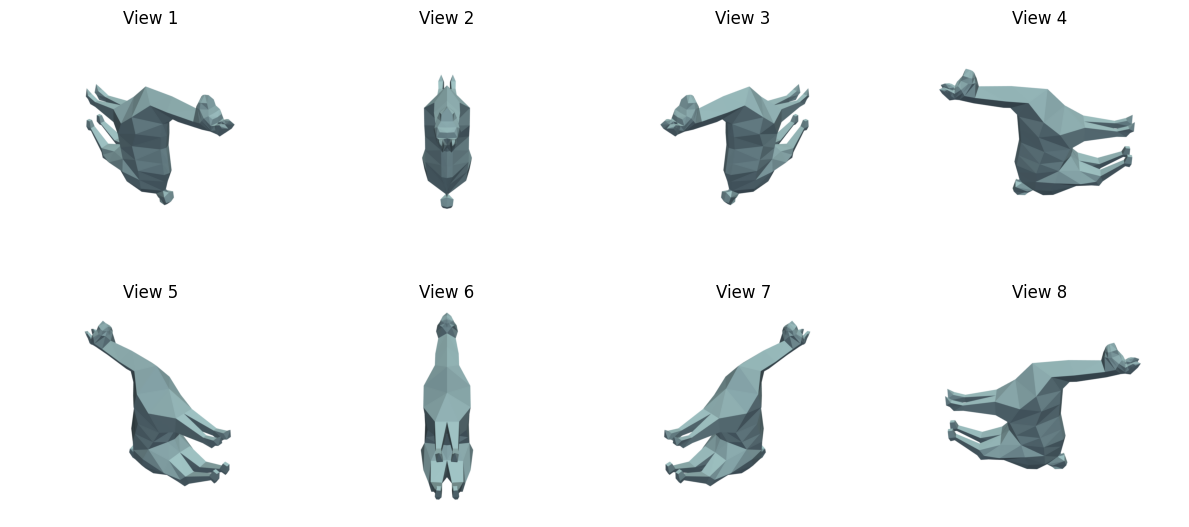

In [10]:
import base64, io, matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, data_url in enumerate(images_array):
    header, b64data = data_url.split(",", 1)
    img_bytes = base64.b64decode(b64data)
    img = plt.imread(io.BytesIO(img_bytes), format='png')
    
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"View {i+1}")

plt.tight_layout()
plt.show()

So, we now know how to render the object into images. All we need to do is:
1) use `att.images` instead of `images_array`.
2) return the `Attachment` object.
3) define the function with two input arguments: the `Attachment` object and the object to render.

Let's dwell on step 3. This step does a little bit of magic.
Although you can give any name to your presenter function, if you use `images`, `text`, `markdown`, etc.,
the pipeline can be more easily defined later.
Let's look back at the pipeline from the beginning.
```python
load.three_d | load.pdf | present.images | adapt.openai_responses
```

The reason we can have two loaders (`three_d` and `pdf`) but only one presenter (`images`) is that
the presenter is many functions that are all named `images`. To know which one to call,
the pipeline will look at the type of `att._obj` and match it to the type hint of the second argument.

Thus, at its core, presenters would look like this:
```python
@presenter
def images(att: Attachment, _obj: "pyvista.MultiBlock") -> Attachment:
  # do something and assign to att.images or att.text
  att.images = ...
  return att
```
So, to recap, by doing the above, we now have a `present.images` that will run whatever is inside 
that function if `att._obj` is a `pyvista.MultiBlock` type or any of its subclasses. 

If we put it all together, we get this:

In [11]:
import copy
@presenter
def images(att: Attachment, notused: "pyvista.MultiBlock") -> Attachment:
    """Presenter for PyVista MultiBlock objects."""
    obj3d = copy.deepcopy(att._obj)   
    mesh_to_render = obj3d
    if isinstance(obj3d, pv.MultiBlock):
        mesh_to_render = obj3d.combine(merge_points=True)

    images_array = []
    print("🎥 Rendering 8 views around the 3D model...")

    for i in range(8):
        # Create a fresh plotter for each view to ensure clean rotation
        p = pv.Plotter(off_screen=True)
        p.add_mesh(mesh_to_render)
        
        # Set camera to isometric view and position it around the object
        p.camera_position = 'iso'
        p.camera.zoom(1.2)
        
        # Rotate the camera around the object (45 degrees per view)
        azimuth_angle = i * 45
        p.camera.azimuth = azimuth_angle
        
        # Take screenshot
        buffer = io.BytesIO()
        p.screenshot(buffer)
        buffer.seek(0)
        images_array.append("data:image/png;base64," + base64.b64encode(buffer.read()).decode())
        
        print(f"   📸 View {i+1}/8 captured (azimuth: {azimuth_angle}°)")
        
        p.close()
    att.images = images_array
    return att  

We were careful not to use `att._obj` directly in the function because presenters
are not supposed to mutate the `Attachment` object. That is the job of modifiers.

Our simple pipeline is now ready to be used.

In [12]:
att_path = "/home/maxime/Projects/attachments/src/attachments/data/Llama.glb"
att = attach(att_path) | load.three_d | present.images
att

[Attachments] Applying step 'load.three_d' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments] Applying step 'present.images' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb


🎥 Rendering 8 views around the 3D model...
   📸 View 1/8 captured (azimuth: 0°)
   📸 View 2/8 captured (azimuth: 45°)
   📸 View 3/8 captured (azimuth: 90°)
   📸 View 4/8 captured (azimuth: 135°)
   📸 View 5/8 captured (azimuth: 180°)
   📸 View 6/8 captured (azimuth: 225°)
   📸 View 7/8 captured (azimuth: 270°)
   📸 View 8/8 captured (azimuth: 315°)


Attachment(path='/home/maxime/Projects/attachments/src/attachments/data/Llama.glb', text=0 chars, images=[8 imgs: data:image/png;base64,iVBORw0K...VORK5CYII=], pipeline=[])


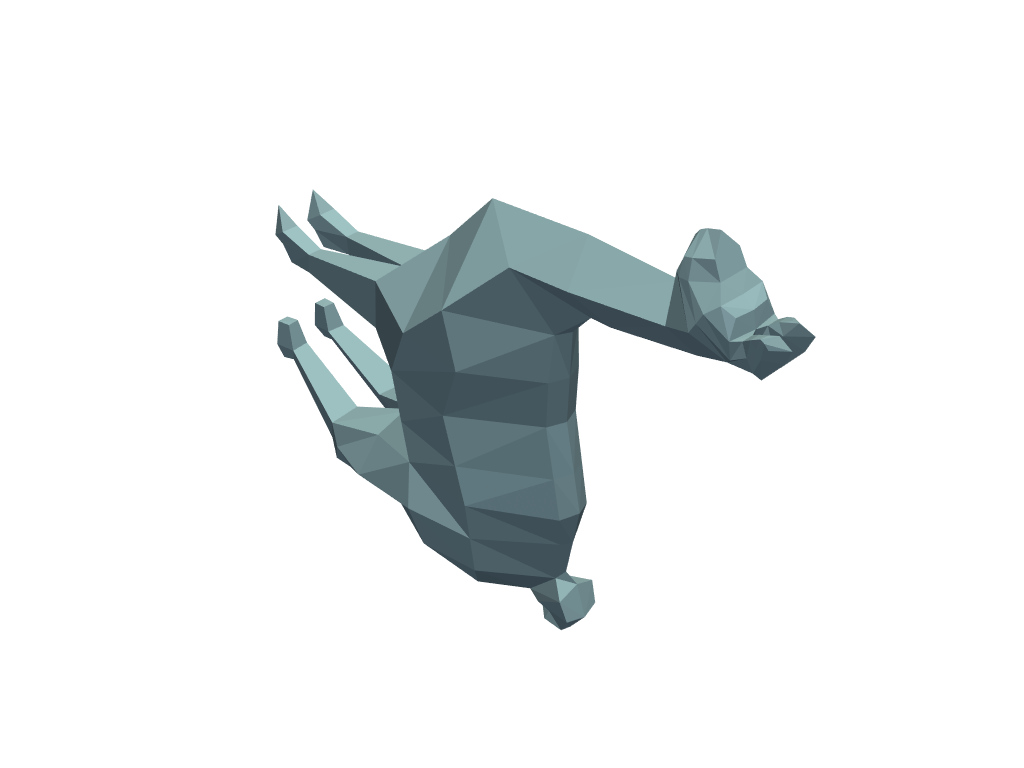
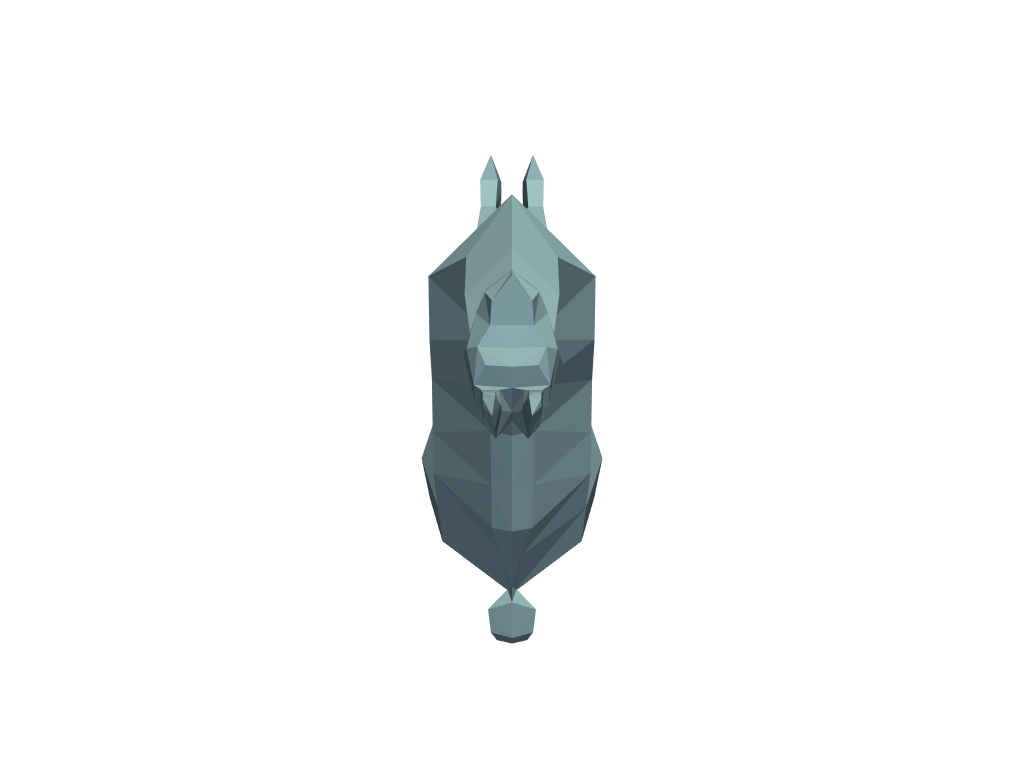
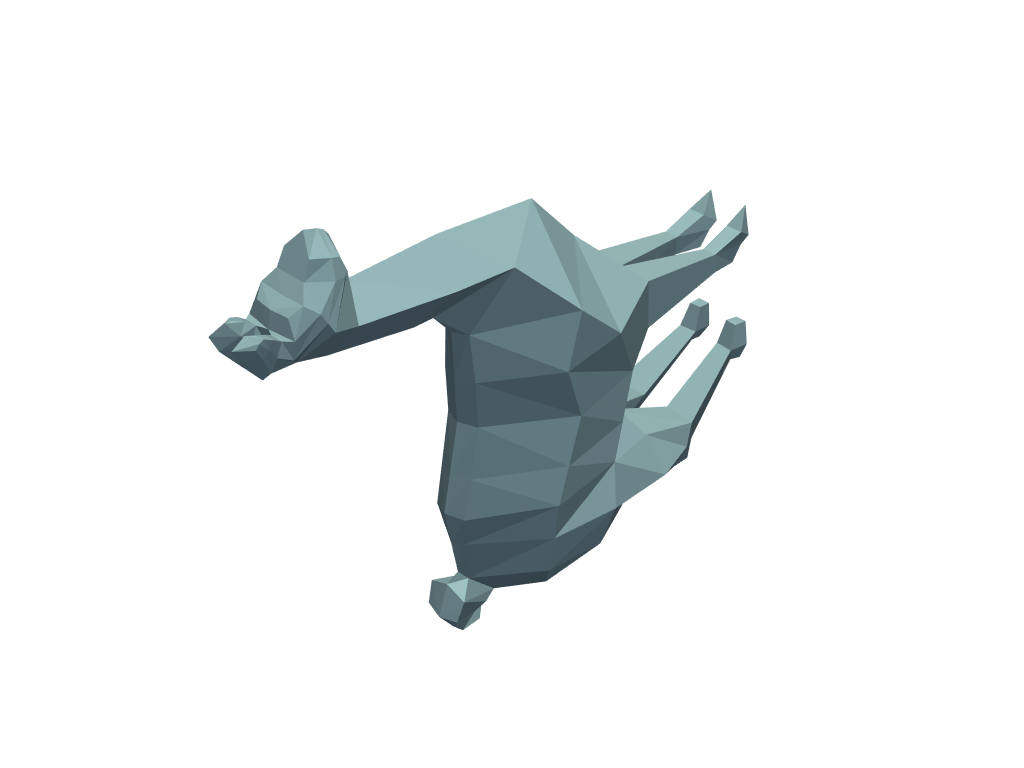
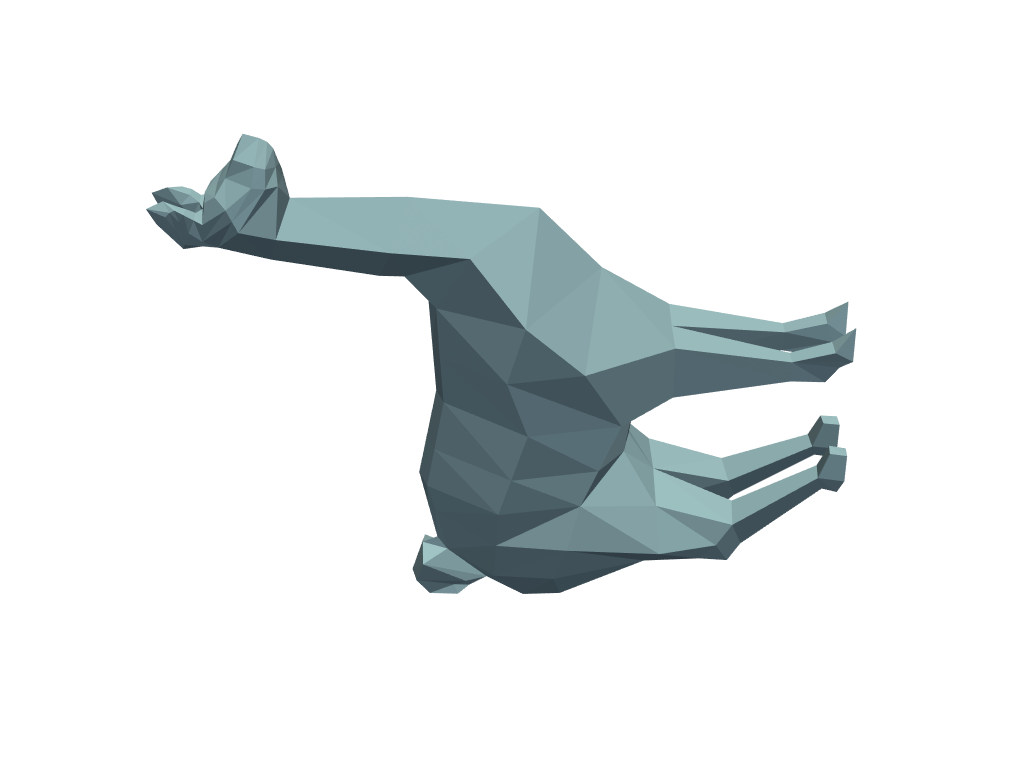
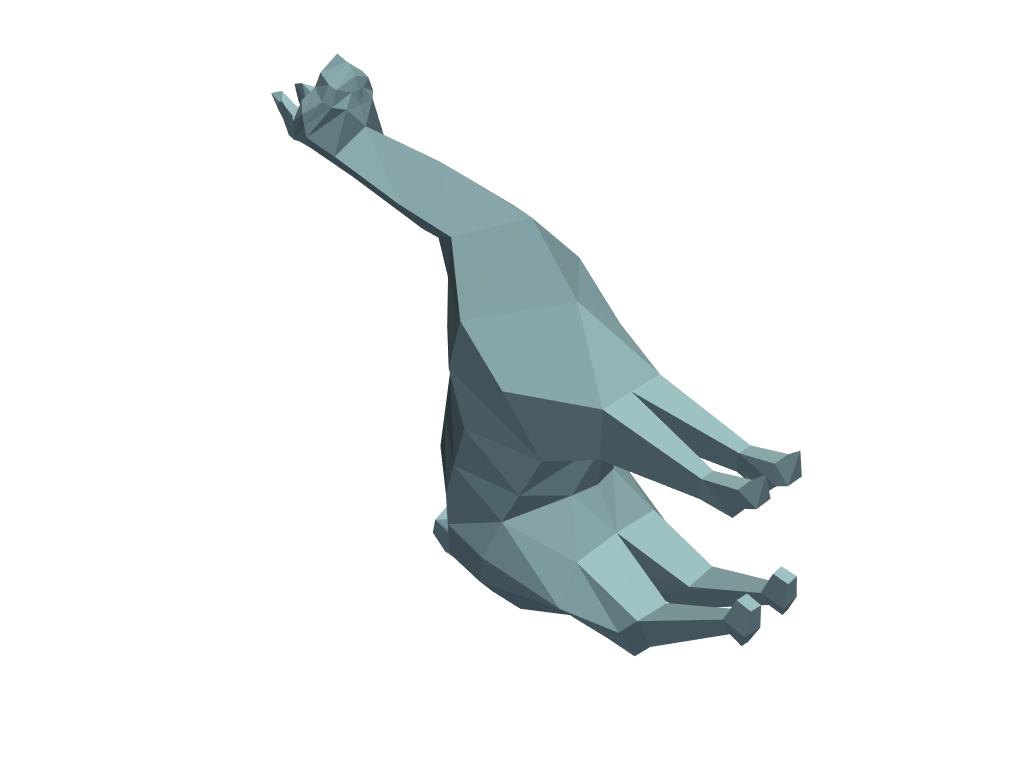
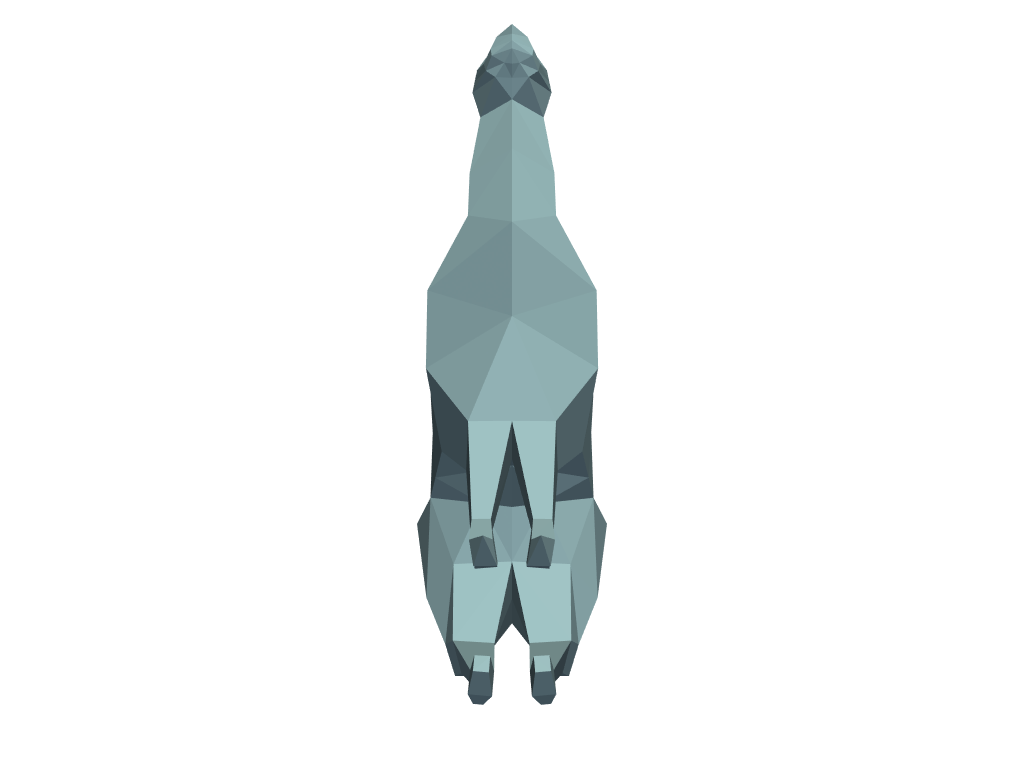
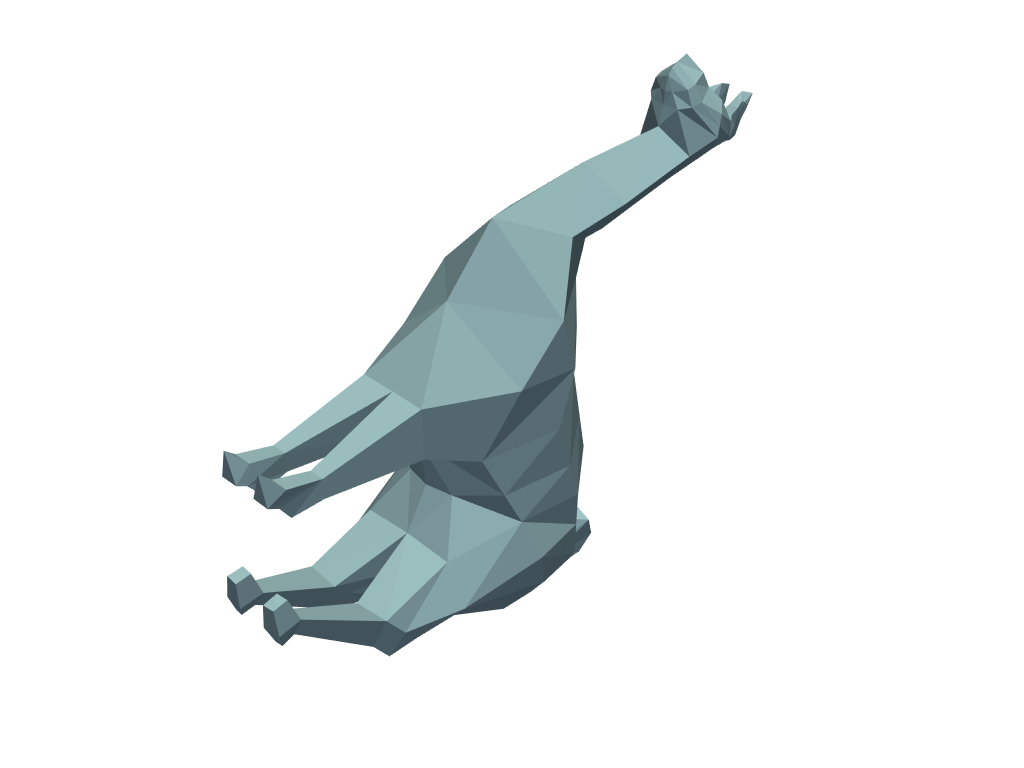
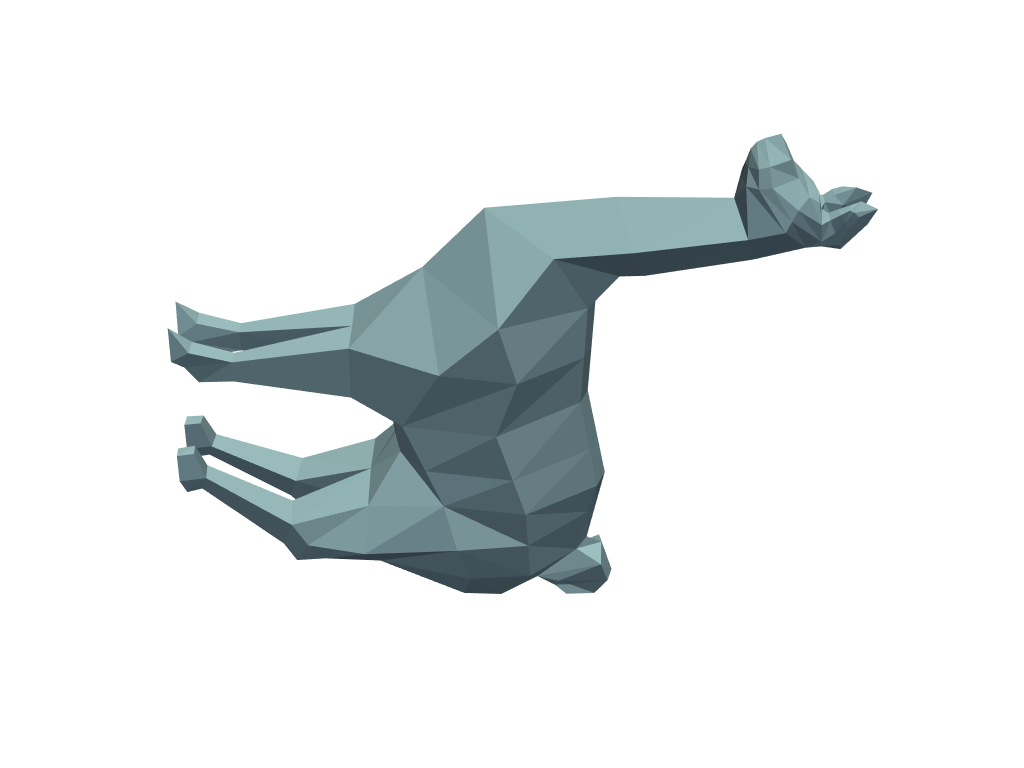

In [13]:
from IPython.display import HTML, display
images_html = ""
for i, data_url in enumerate(att.images):
    style = f"width:150px; display:inline-block; margin:2px; border:1px solid #ddd"
    images_html += f'<img src="{data_url}" style="{style}" />'
    if (i + 1) % 4 == 0:
        images_html += "<br>"
display(HTML(images_html))

We can already use the attachment to call any adapter that already exists in the library and 
any that will be added in the future.

Here is an example of using the Claude adapter. It returns a messages list ready to be used with the Claude API.

In [14]:
att.claude("What do you see?")

[{'role': 'user',
  'content': [{'type': 'text', 'text': 'What do you see?'},
   {'type': 'image',
    'source': {'type': 'base64',
     'media_type': 'image/png',
     'data': 'iVBORw0KGgoAAAANSUhEUgAABAAAAAMACAIAAAA12IJaAACnMElEQVR4nO39eZwcV33v/5+q3ma6Z9OMNDNaLFm25U2WZZvNCWAwGGNskpsEG4NZwhIS1i8JNyQQAoQtF+cXkgAmgeTCJQtrDCEJsVlsDNiAjfEiyZIlS15kbbPv01t1Vf3+ODOlmu7q6urq6rVez/hBZnq6q0vbzHmf8/mco5imKQAAAACEg9rsGwAAAADQOAQAAAAAIEQIAAAAAECIEAAAAACAECEAAAAAACFCAAAAAABChAAAAAAAhAgBAAAAAAgRAgAAAAAQIgQAAAAAIEQIAAAAAECIEAAAAACAECEAAAAAACFCAAAAAABChAAAAAAAhAgBAAAAAAgRAgAAAAAQIgQAAAAAIEQIAAAAAECIEAAAAACAECEAAAAAACFCAAAAAABChAAAAAAAhAgBAAAAAAgRAgAAAAAQIgQAAAAAIEQIAAAAAECIEAAAAACAECEAAAAAACFCAAAAAABChAAAAAAAhAgBAAAAAAgRAgAAAAAQIgQAAAAAIEQIAAAAAECIEAAAAACAECEAAAAAACFCAAAAAABChAAAAAAAhAgBAAAAAAgRAgAAAAAQIgQAAAAAIEQIAAAAAECIEAAAAACAECEAAAAAACFCAAAAAABChAAAAAAAhAgBAAAAAAgRAgAAAAAQIgQAAAAAIEQIAAAAAECIEAAAAACAECEAAAAAACFCAAAAAABChAAAAAAAhAgBAAAAAAgRAgAAAAAQIgQAAAAAIEQIAAAAAECIEAAAAACAECEAAAAAACFCAAAAAABChA

If we want to render our attachments both as text and as images, we can also add a text presenter.
In the example below, we define a text presenter that simply adds the path and the bounds of the object to the attachment object.

In [15]:
@presenter
def text(att: Attachment, notused: "pyvista.MultiBlock") -> Attachment:
    att.text = f"{att.path} bounds: {att._obj.bounds}"
    return att

# Simple pipeline.
# This pipeline is a simple pipeline that loads the object, renders it into images,
# and then renders the object into text.
pipe = load.three_d | present.images + present.text
att = pipe("/home/maxime/Projects/attachments/src/attachments/data/Llama.glb")
att.text

🎥 Rendering 8 views around the 3D model...


[Attachments] Applying step 'load.three_d' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments] Running AdditivePipeline(present.images + present.text)
[Attachments]   Applying additive step 'present.images' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb


   📸 View 1/8 captured (azimuth: 0°)
   📸 View 2/8 captured (azimuth: 45°)
   📸 View 3/8 captured (azimuth: 90°)
   📸 View 4/8 captured (azimuth: 135°)
   📸 View 5/8 captured (azimuth: 180°)
   📸 View 6/8 captured (azimuth: 225°)
   📸 View 7/8 captured (azimuth: 270°)
   📸 View 8/8 captured (azimuth: 315°)


[Attachments]   Applying additive step 'present.text' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb


'/home/maxime/Projects/attachments/src/attachments/data/Llama.glb bounds: BoundsTuple(x_min=-0.46895235776901245, x_max=0.46895235776901245, y_min=-0.04647529125213623, y_max=3.2271273136138916, z_min=-1.3846513032913208, z_max=1.3091562986373901)'

The power of attachments comes from the promise of a single line for loading and processing
any file type using `Attachments()`.

For this to work, we need to register our pipeline with the `processor` decorator.

Like this:

In [16]:
from attachments.pipelines import processor

@processor(
    match=glb_match,
    description="A custom GLB processor"
)
def glb_to_llm(att: Attachment) -> Attachment:
    return att | load.three_d | present.images + present.text

Like for the loader, we must define a matcher to 'gate' the pipeline.
Nothing prevents us from doing something very complex inside the pipeline; it could be a multi-stage
pipeline with multiple loaders and presenters.

In this example, we kept it simple and just registered what we already had.

And so, finally, we can use `Attachments()` with our newly supported file type and all the ones that ship
with the library.

Let's try it out.

In [17]:
from attachments import Attachments
att1 = Attachments("/home/maxime/Projects/attachments/src/attachments/data/Llama.glb")
att1

[Attachments] Running primary processor 'glb_to_llm' for /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments]   Applying step 'load.three_d' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments]   Running AdditivePipeline(present.images + present.text)
[Attachments]     Applying additive step 'present.images' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb


🎥 Rendering 8 views around the 3D model...
   📸 View 1/8 captured (azimuth: 0°)
   📸 View 2/8 captured (azimuth: 45°)
   📸 View 3/8 captured (azimuth: 90°)
   📸 View 4/8 captured (azimuth: 135°)
   📸 View 5/8 captured (azimuth: 180°)
   📸 View 6/8 captured (azimuth: 225°)
   📸 View 7/8 captured (azimuth: 270°)
   📸 View 8/8 captured (azimuth: 315°)


[Attachments]     Applying additive step 'present.text' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb


Attachments([glb(246chars, 8imgs, img: data:image/png;base64,iVBORw0K...VORK5CYII=)])


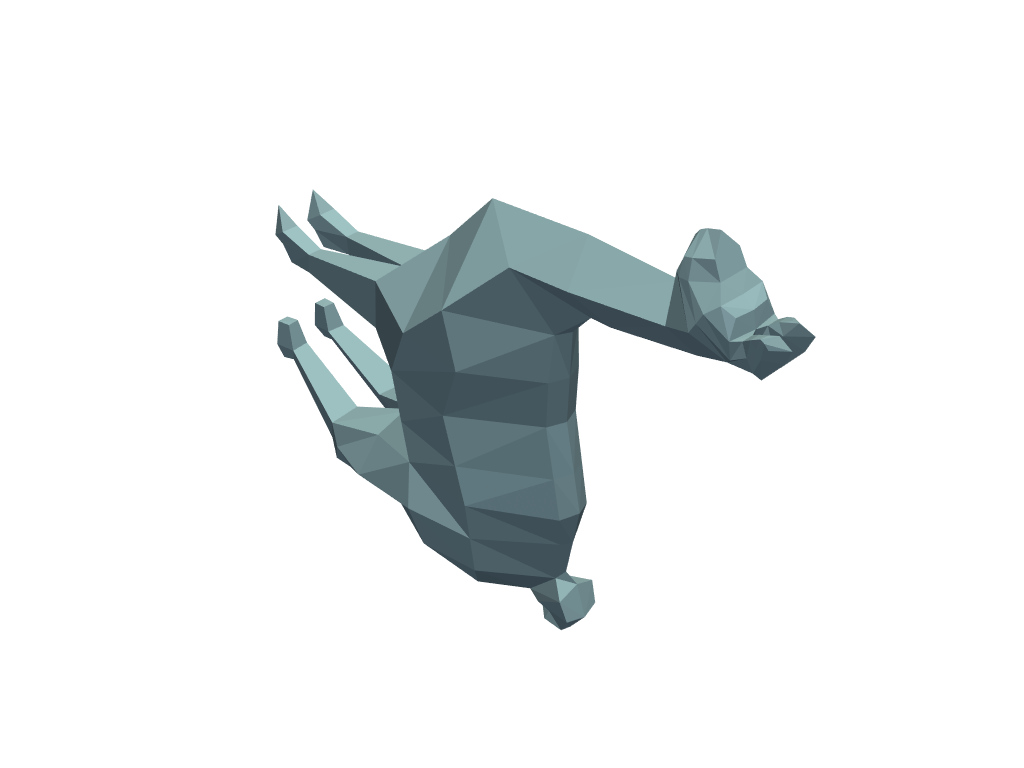
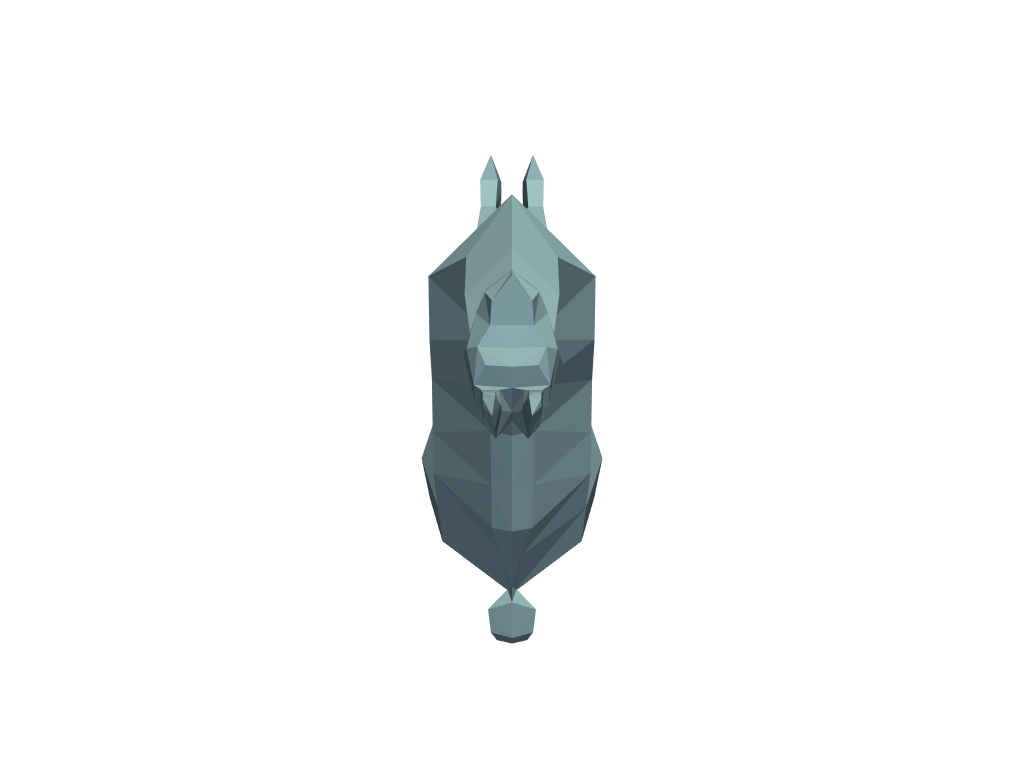
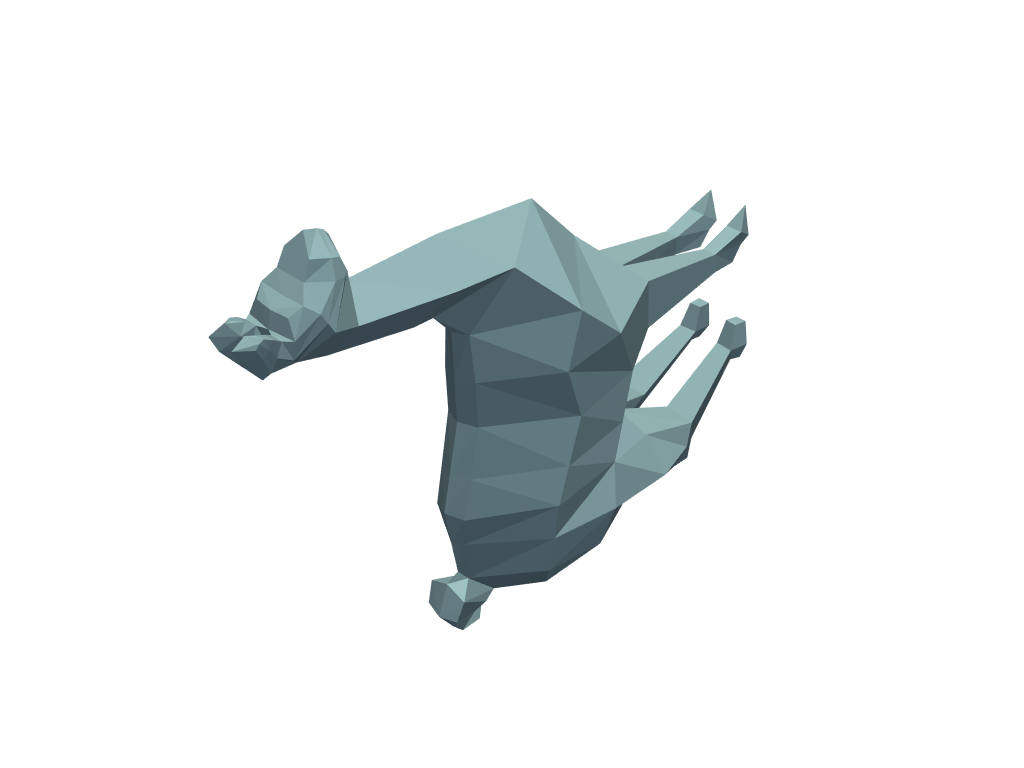
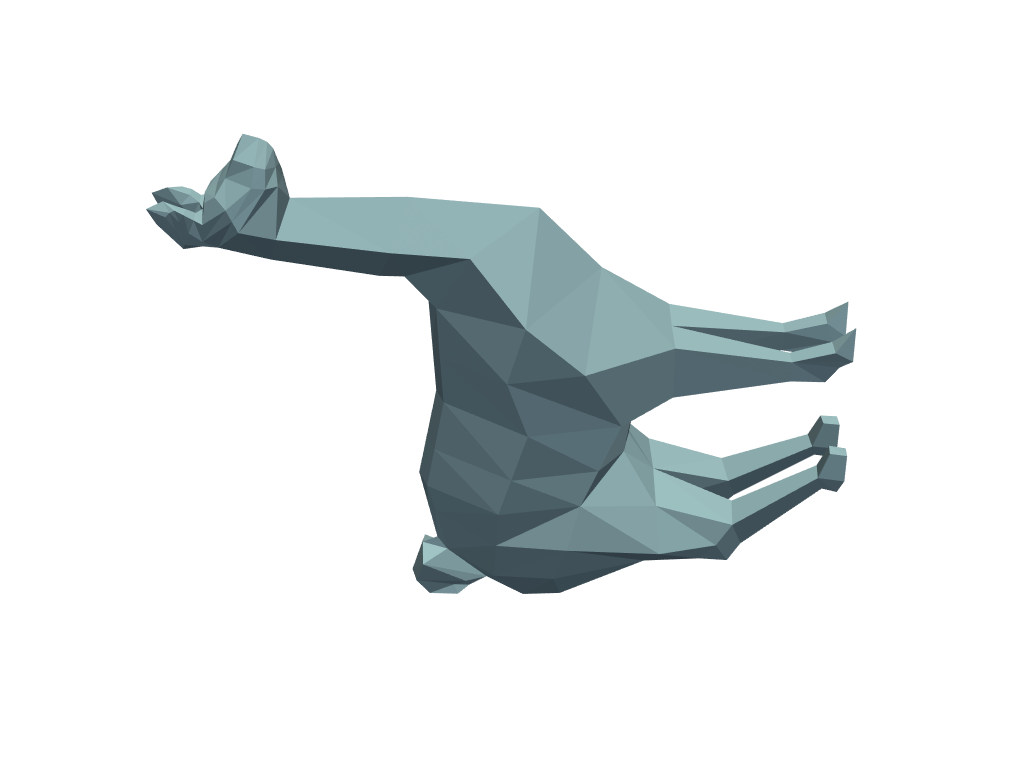
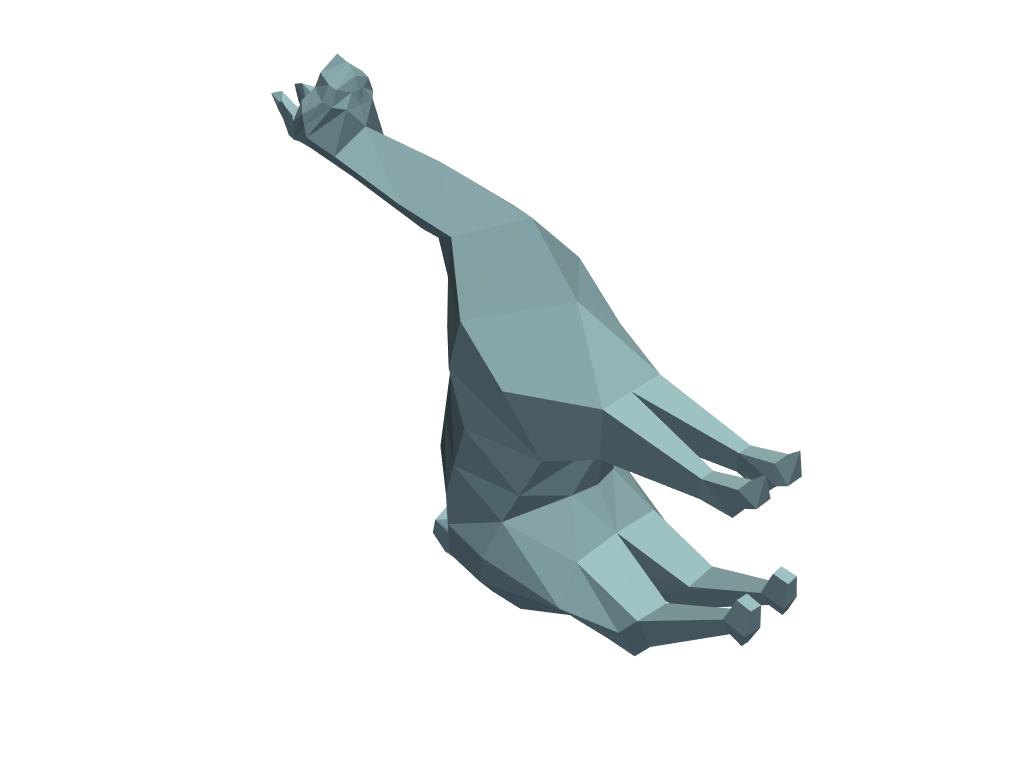
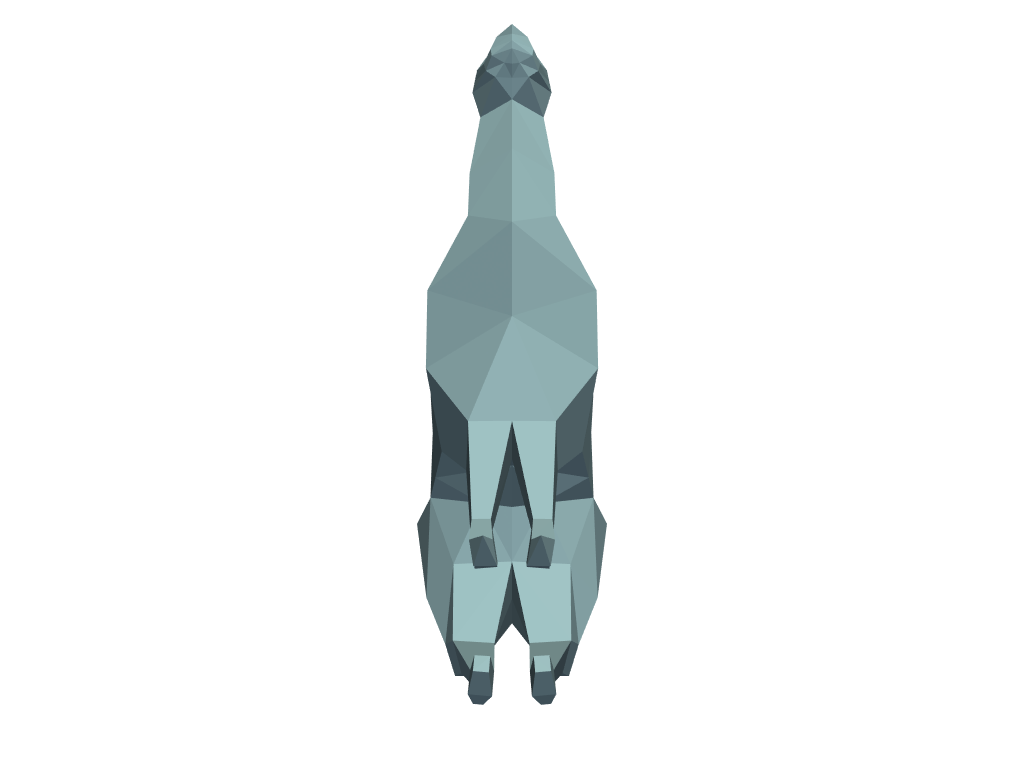
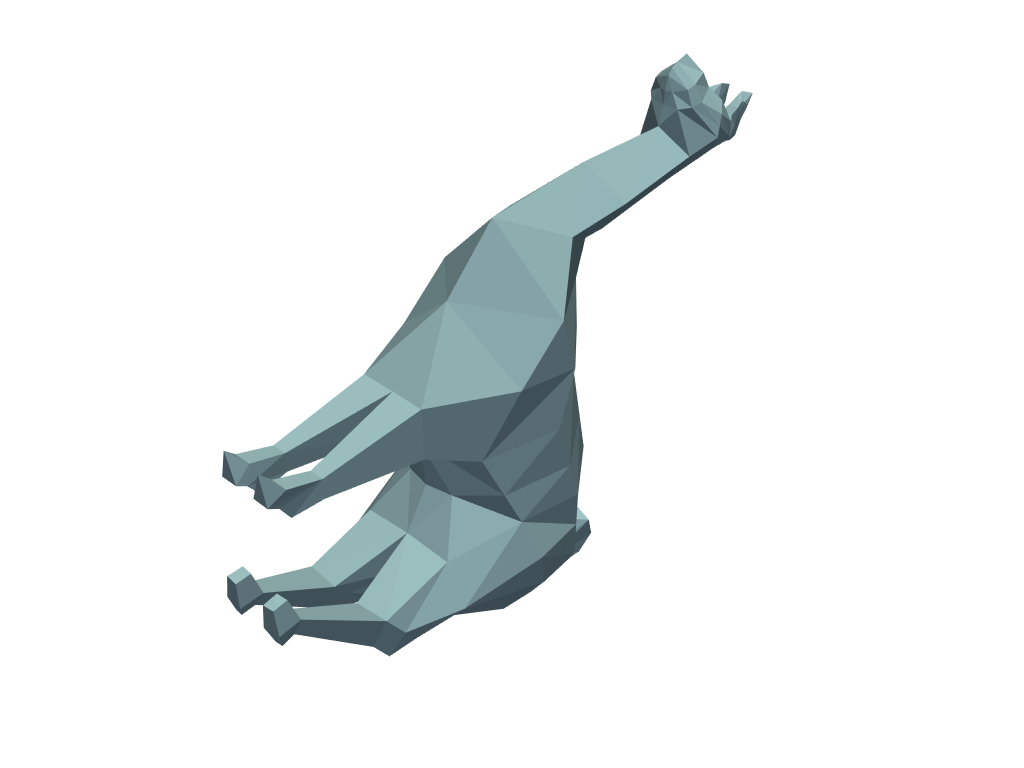
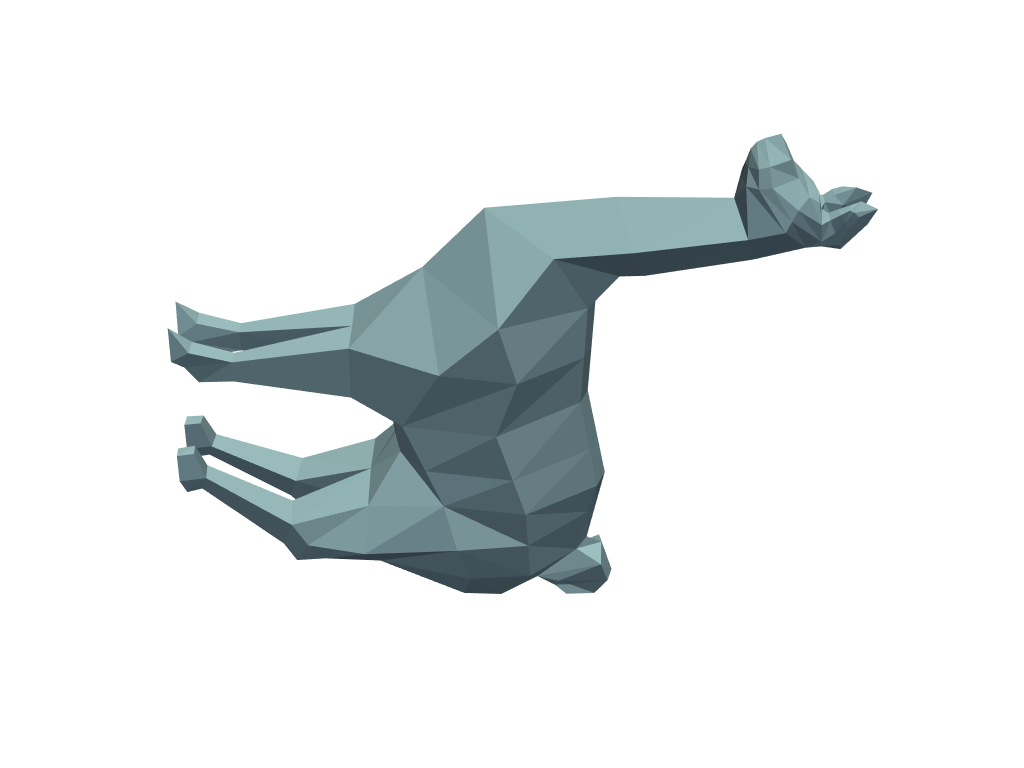

In [18]:
from IPython.display import HTML, display
images_html = ""
for i, data_url in enumerate(att1.images):
    style = f"width:150px; display:inline-block; margin:2px; border:1px solid #ddd"
    images_html += f'<img src="{data_url}" style="{style}" />'
    if (i + 1) % 4 == 0:
        images_html += "<br>"
display(HTML(images_html))

Or simply loading a web page.

In [19]:
att2 = Attachments("https://en.wikipedia.org/wiki/Llama_(language_model)[images: false]")
att2

[Attachments] Parsed commands for 'https://en.wikipedia.org/wiki/Llama_(language_model)[images: false]': {'images': 'false'}
[Attachments] Running primary processor 'webpage_to_llm' for https://en.wikipedia.org/wiki/Llama_(language_model)
[Attachments]   Accessing command: 'images' = 'false'
[Attachments]   Applying step 'load.url_to_bs4' to https://en.wikipedia.org/wiki/Llama_(language_model)
[Attachments]   Running AdditivePipeline(present.markdown + present.metadata)
[Attachments]     Applying additive step 'present.markdown' to https://en.wikipedia.org/wiki/Llama_(language_model)
[Attachments]     Applying additive step 'present.metadata' to https://en.wikipedia.org/wiki/Llama_(language_model)
[Attachments]   Applying step 'refine.add_headers' to https://en.wikipedia.org/wiki/Llama_(language_model)


Attachments([org/wiki/llama_(language_model)(91864chars, 0imgs)])

# Advanced Verbs
Let's go one step further and add a splitter, a modifier, and a refiner.

## Splitter
The splitter is a function that takes an `Attachment` object and returns a list of `Attachment` objects.
Let's split all rendered 3D views into their own `Attachment` objects.
This is useful when you want to process each view separately or send individual views to different LLMs.

In [20]:
from attachments import split
from attachments.core import splitter, AttachmentCollection

@splitter
def views(att: Attachment, notused: "pyvista.MultiBlock") -> AttachmentCollection:
    """Split 3D model attachment into individual view attachments."""
    if not att.images:
        return AttachmentCollection([att])  # Return original if no images
    
    view_attachments = []
    for i, image in enumerate(att.images):
        # Create new attachment for each view
        view_att = Attachment(f"{att.path}#view-{i+1}")
        view_att.images = [image]  # Single image per attachment
        view_att.text = f"View {i+1} of 3D model: {att.path}"
        view_att.commands = att.commands
        view_att.metadata = {
            **att.metadata,
            'chunk_type': 'view',
            'view_index': i,
            'total_views': len(att.images),
            'original_path': att.path,
            'azimuth_angle': i * 45  # Each view is 45 degrees apart
        }
        view_attachments.append(view_att)
    
    return AttachmentCollection(view_attachments)

Now we can use the splitter to break our 3D model into individual views:

In [21]:
# Load and render the 3D model
att = attach("/home/maxime/Projects/attachments/src/attachments/data/Llama.glb") | load.three_d | present.images + present.text

# Split into individual views
view_collection = att | split.views

print(f"Original attachment had {len(att.images)} images")
print(f"Split into {len(view_collection)} individual view attachments")
print(f"Each view attachment has {len(view_collection[0].images)} image")

# You can now process each view separately
for i, view in enumerate(view_collection):
    print(f"View {i+1}: {view.text}")

[Attachments] Applying step 'load.three_d' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments] Running AdditivePipeline(present.images + present.text)
[Attachments]   Applying additive step 'present.images' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb


🎥 Rendering 8 views around the 3D model...
   📸 View 1/8 captured (azimuth: 0°)
   📸 View 2/8 captured (azimuth: 45°)
   📸 View 3/8 captured (azimuth: 90°)
   📸 View 4/8 captured (azimuth: 135°)
   📸 View 5/8 captured (azimuth: 180°)
   📸 View 6/8 captured (azimuth: 225°)
   📸 View 7/8 captured (azimuth: 270°)
   📸 View 8/8 captured (azimuth: 315°)
Original attachment had 8 images
Split into 8 individual view attachments
Each view attachment has 1 image
View 1: View 1 of 3D model: /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
View 2: View 2 of 3D model: /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
View 3: View 3 of 3D model: /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
View 4: View 4 of 3D model: /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
View 5: View 5 of 3D model: /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
View 6: View 6 of 3D model: /home/maxime/Projects/attachments/src/attachments

[Attachments]   Applying additive step 'present.text' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments] Applying step 'split.views' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb


## Modifier
Modifiers allow us to transform the loaded object before presentation. A modifier takes an `Attachment` object, changes its `._obj` attribute in place, and returns the modified `Attachment`. This is useful for applying transformations based on user commands before the presentation step.

The `scale` modifier we tried earlier wasn't visually obvious because the renderer automatically zooms to fit the object. Let's create a more apparent modifier: `decimate`. Decimation reduces the number of faces in a 3D model to simplify it. This will give our model a "low-poly" look, which is a very clear visual change.

We'll use a DSL command like `[decimate: 0.8]` to control the percentage of reduction (in this case, by 80%).

In [22]:
from attachments import modify
from attachments.core import modifier
import copy

@modifier
def decimate(att: Attachment, notused: "pyvista.MultiBlock") -> Attachment:
    """
    Decimates a 3D model using a DSL command `[decimate: reduction_factor]`.
    Example: `[decimate: 0.8]` will reduce the number of faces by 80%.
    """

    if 'decimate' not in att.commands:
        return att

    try:
        factor = float(att.commands['decimate'])
        if not (0 < factor < 1):
            raise ValueError("Decimation factor must be between 0 and 1.")

        combined_mesh = att._obj.combine(merge_points=True)
        surface_mesh = combined_mesh.extract_surface()

        original_cells = surface_mesh.n_cells
        decimated_surface = surface_mesh.decimate(factor)
        
        # Wrap the decimated PolyData back into a MultiBlock to maintain type consistency
        att._obj = pv.MultiBlock([decimated_surface])
        
        att.metadata['decimation_factor'] = factor
        att.metadata['original_faces'] = original_cells
        att.metadata['decimated_faces'] = decimated_surface.n_cells

    except Exception as e:
        att.metadata['decimate_error'] = str(e)

    return att

Now, let's use this `decimate` modifier in a pipeline.

In [23]:
from attachments.core import Pipeline
# Let's define a pipeline that includes our `decimate` modifier.
decimation_pipeline = Pipeline([
    load.three_d,
    modify.decimate,
    present.images
])

# Low-poly model (90% reduction)
print("Processing decimated model (90% reduction)...")
att_low_poly = decimation_pipeline("/home/maxime/Projects/attachments/src/attachments/data/Llama.glb[decimate:0.9]")

Processing decimated model (90% reduction)...
🎥 Rendering 8 views around the 3D model...


[Attachments] Parsed commands for '/home/maxime/Projects/attachments/src/attachments/data/Llama.glb[decimate:0.9]': {'decimate': '0.9'}
[Attachments] Applying step 'load.three_d' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments] Applying step 'modify.decimate' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments]   Accessing command: 'decimate' = '0.9'
[Attachments] Applying step 'present.images' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb


   📸 View 1/8 captured (azimuth: 0°)
   📸 View 2/8 captured (azimuth: 45°)
   📸 View 3/8 captured (azimuth: 90°)
   📸 View 4/8 captured (azimuth: 135°)
   📸 View 5/8 captured (azimuth: 180°)
   📸 View 6/8 captured (azimuth: 225°)
   📸 View 7/8 captured (azimuth: 270°)
   📸 View 8/8 captured (azimuth: 315°)



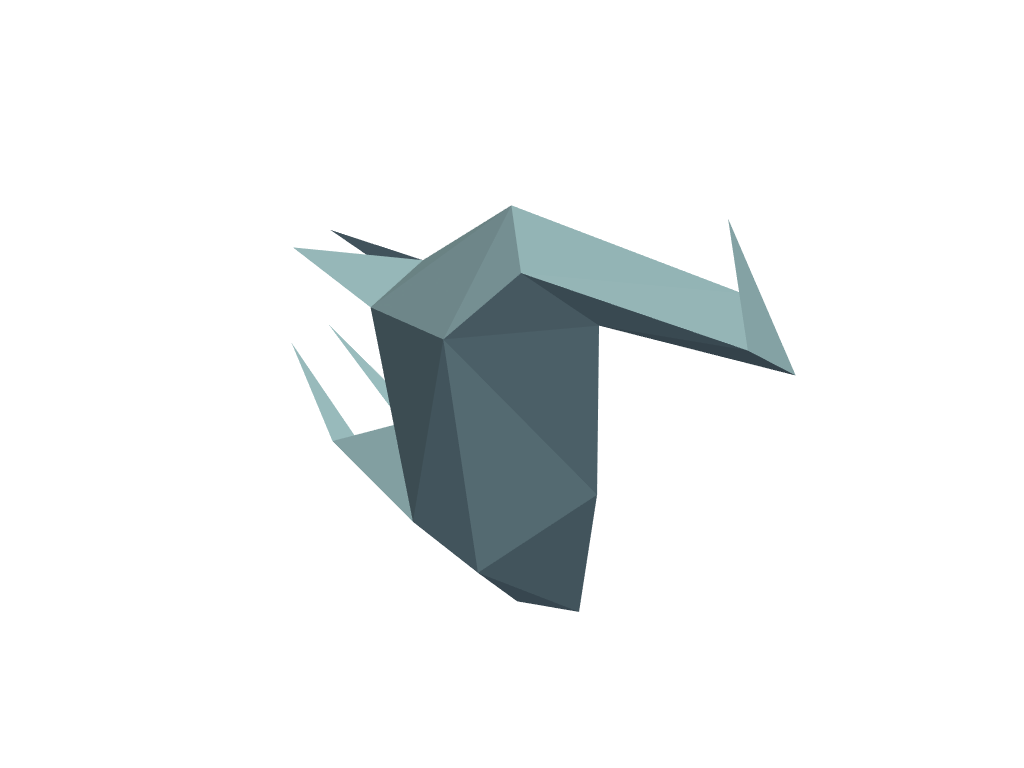
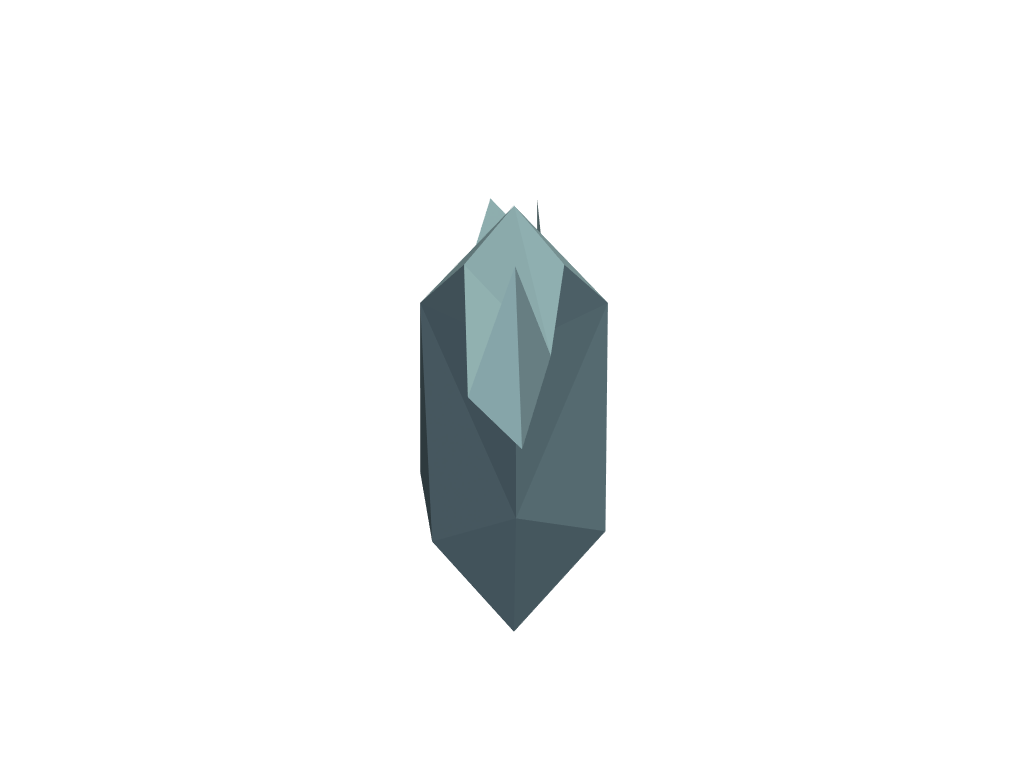
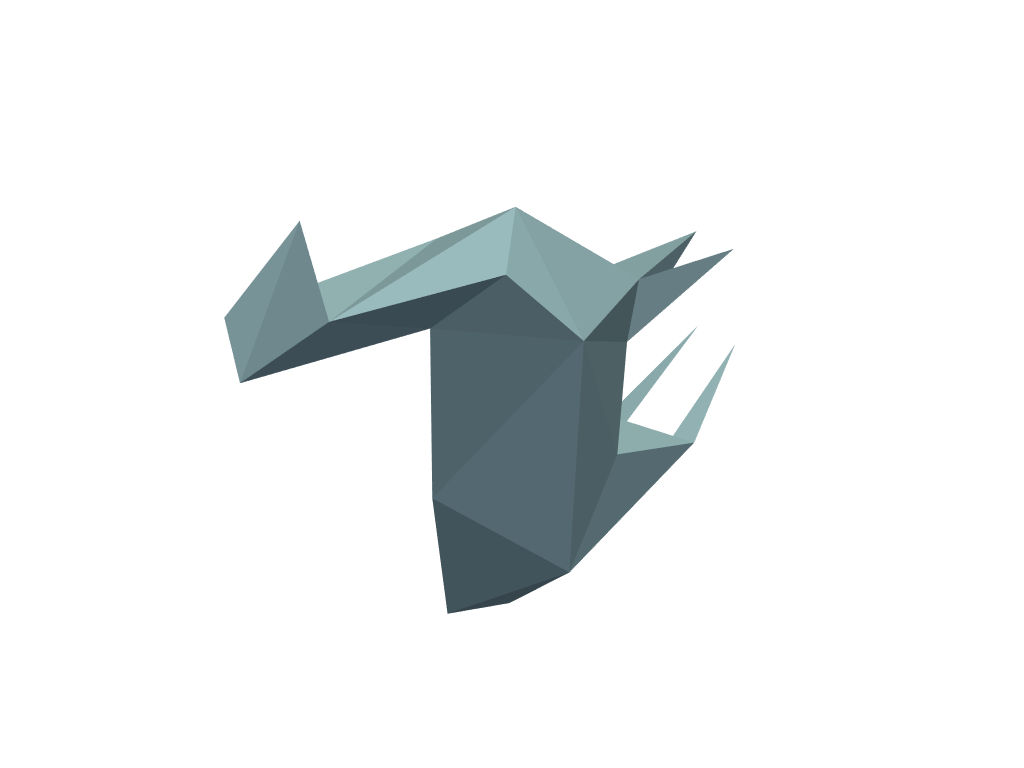
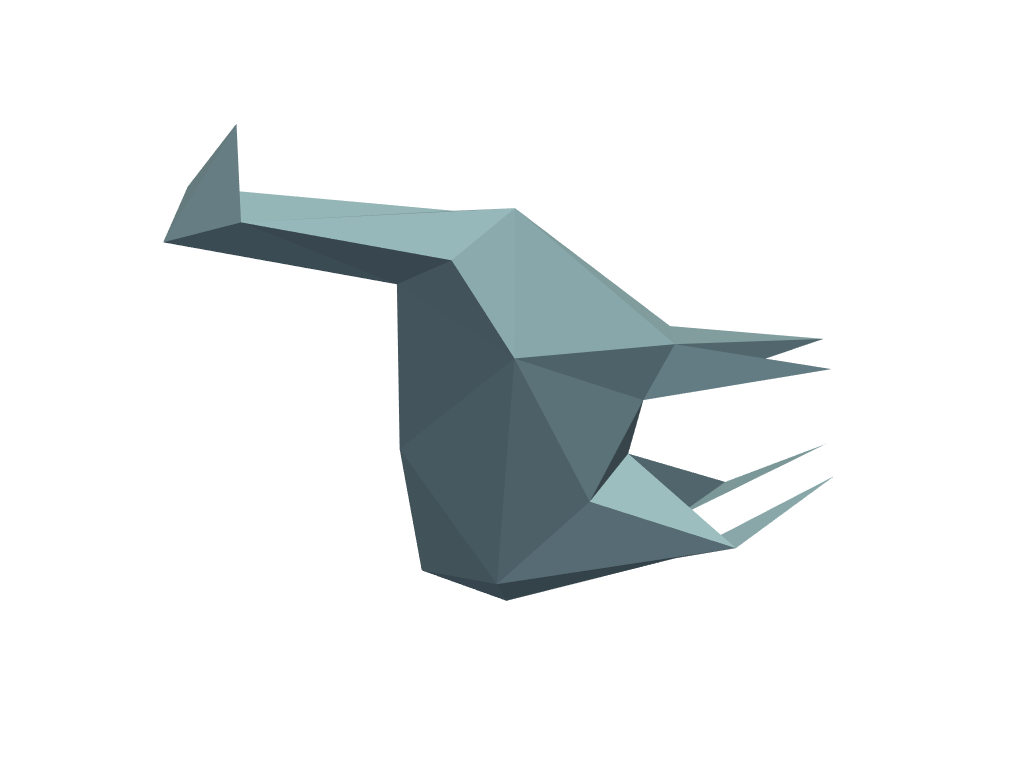
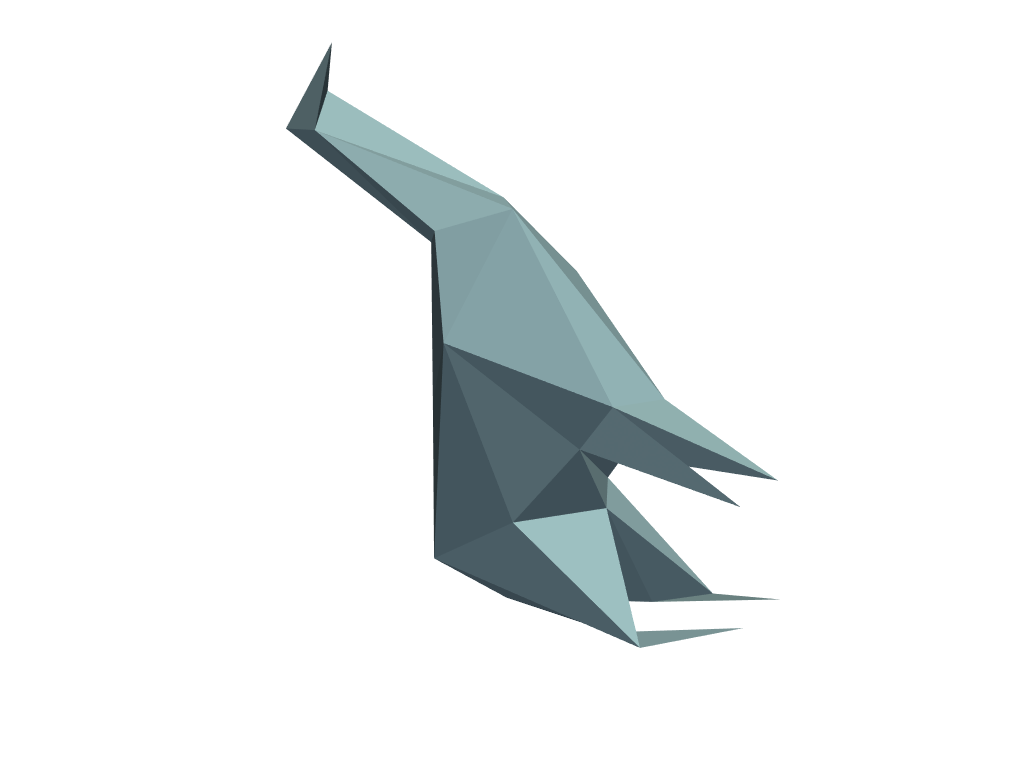
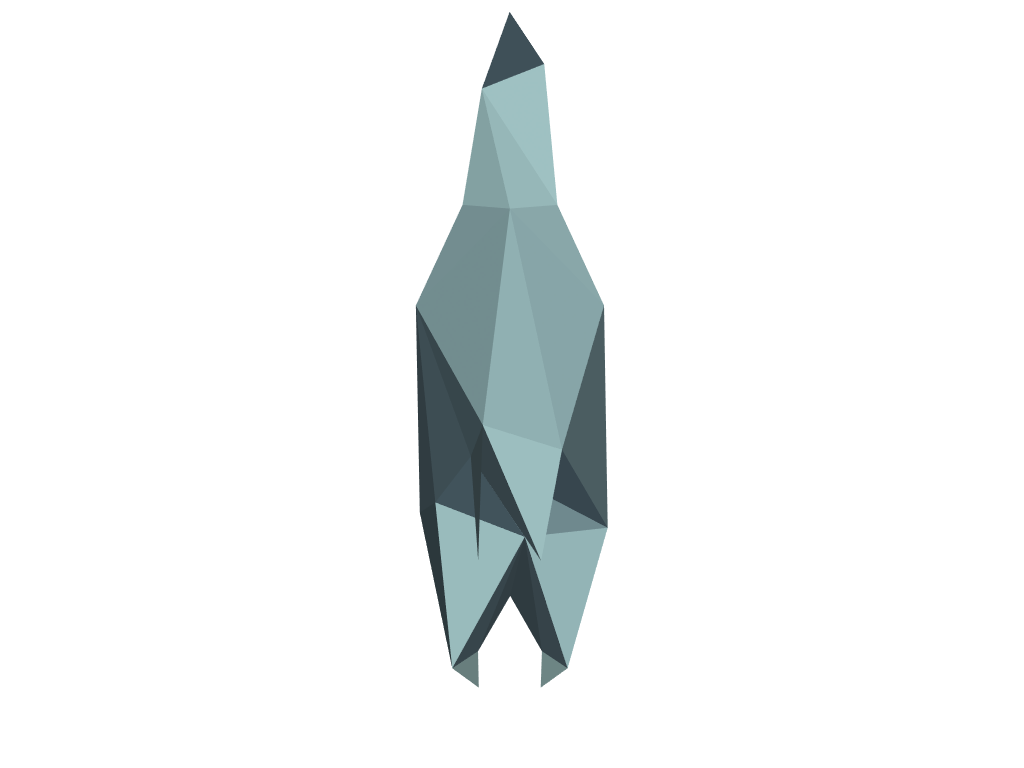
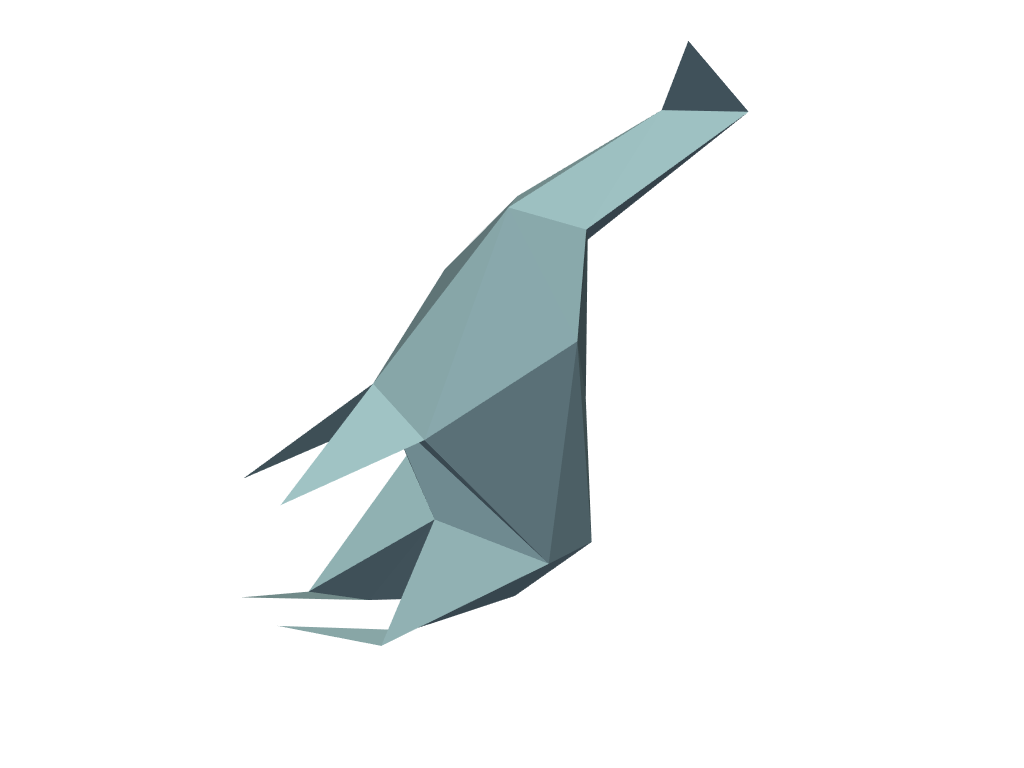
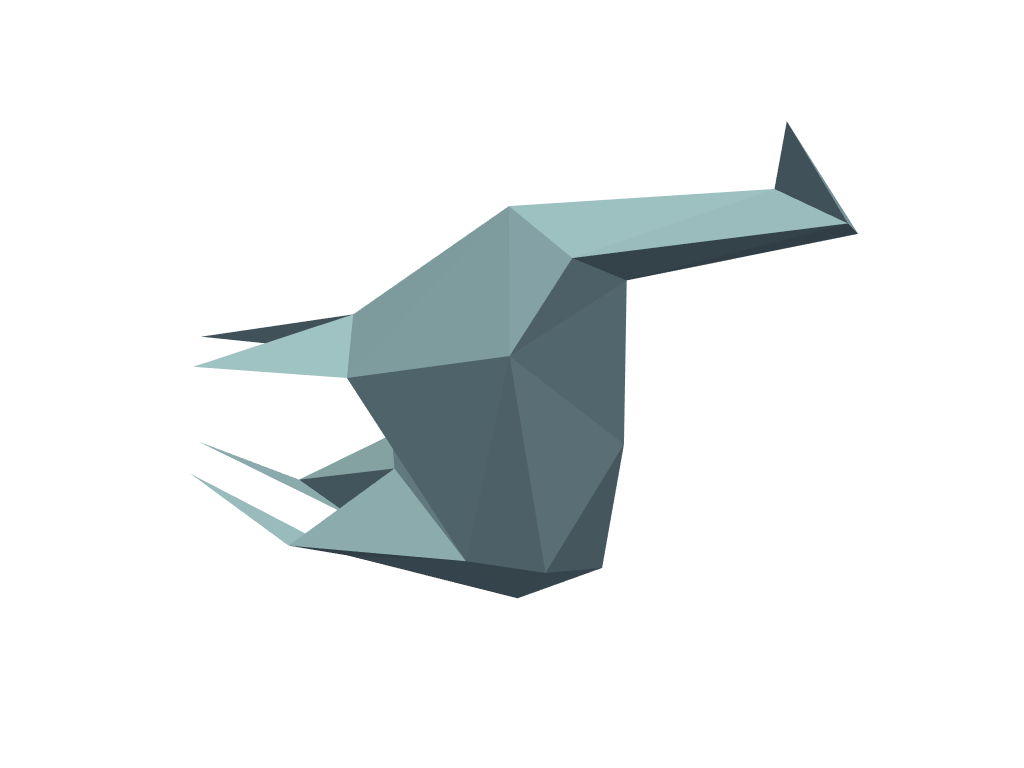

In [24]:

images_html = ""
for i, data_url in enumerate(att_low_poly.images):
    style = f"width:150px; display:inline-block; margin:2px; border:1px solid #ddd"
    images_html += f'<img src="{data_url}" style="{style}" />'
    if (i + 1) % 4 == 0:
        images_html += "<br>"
display(HTML(images_html))

In [25]:
# Low-poly model (97% reduction)
print("Processing decimated model (97% reduction)...")
att_low_poly = decimation_pipeline("/home/maxime/Projects/attachments/src/attachments/data/Llama.glb[decimate:0.97]")

Processing decimated model (97% reduction)...
🎥 Rendering 8 views around the 3D model...


[Attachments] Parsed commands for '/home/maxime/Projects/attachments/src/attachments/data/Llama.glb[decimate:0.97]': {'decimate': '0.97'}
[Attachments] Applying step 'load.three_d' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments] Applying step 'modify.decimate' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb
[Attachments]   Accessing command: 'decimate' = '0.97'
[Attachments] Applying step 'present.images' to /home/maxime/Projects/attachments/src/attachments/data/Llama.glb


   📸 View 1/8 captured (azimuth: 0°)
   📸 View 2/8 captured (azimuth: 45°)
   📸 View 3/8 captured (azimuth: 90°)
   📸 View 4/8 captured (azimuth: 135°)
   📸 View 5/8 captured (azimuth: 180°)
   📸 View 6/8 captured (azimuth: 225°)
   📸 View 7/8 captured (azimuth: 270°)
   📸 View 8/8 captured (azimuth: 315°)



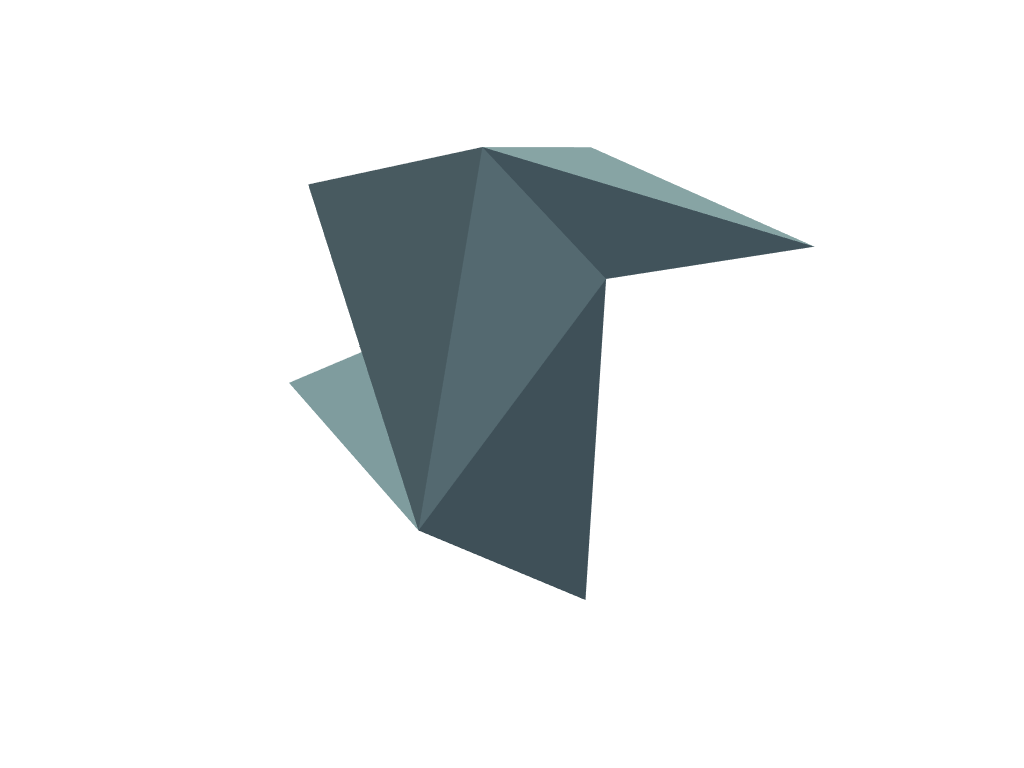
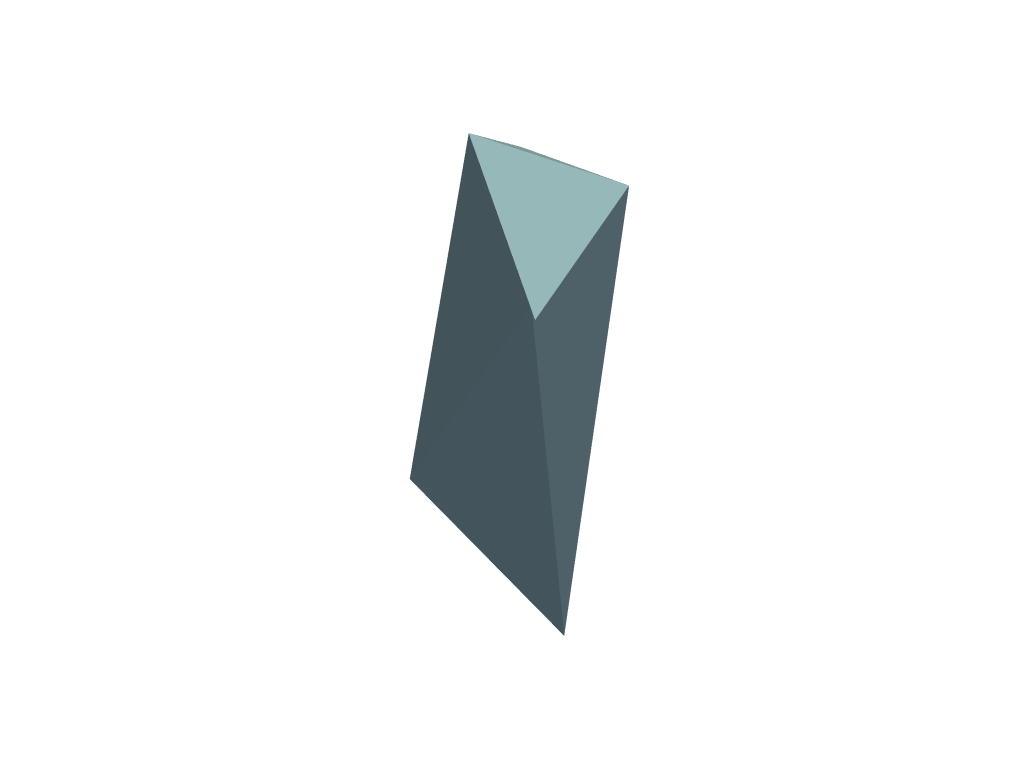
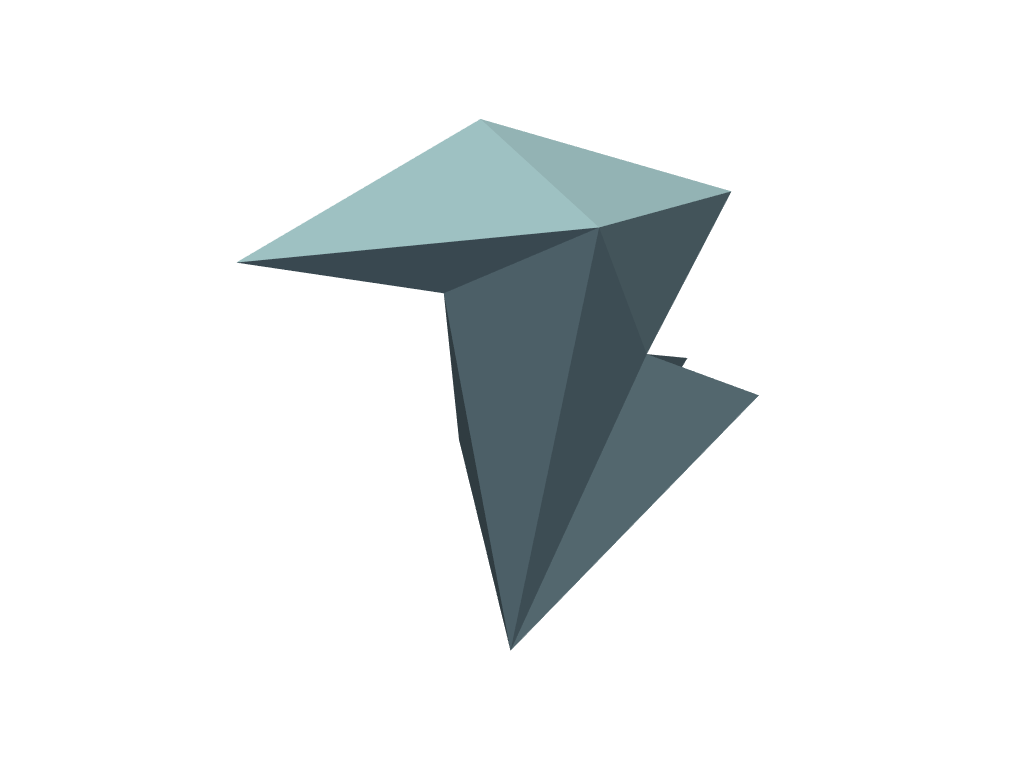
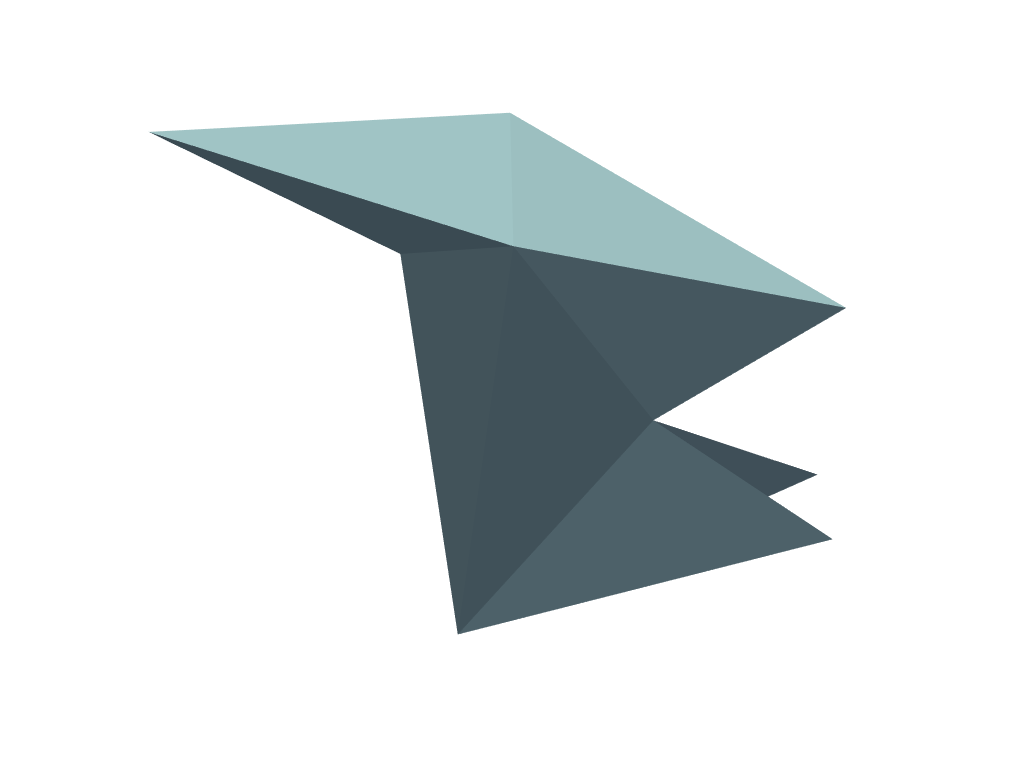
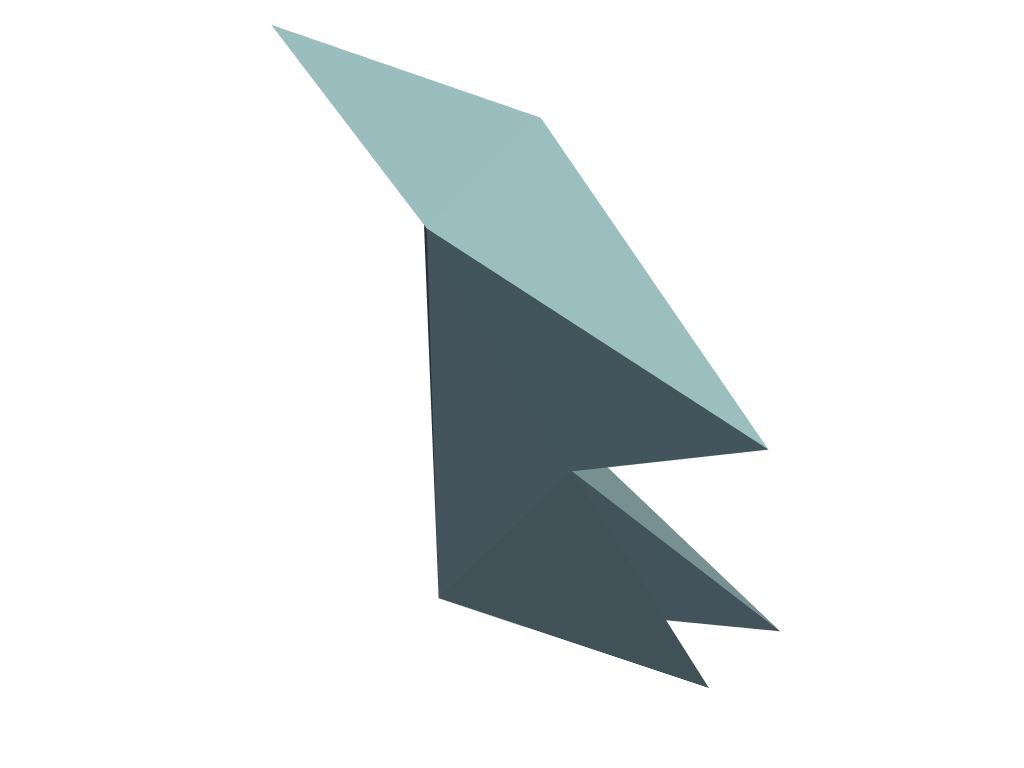
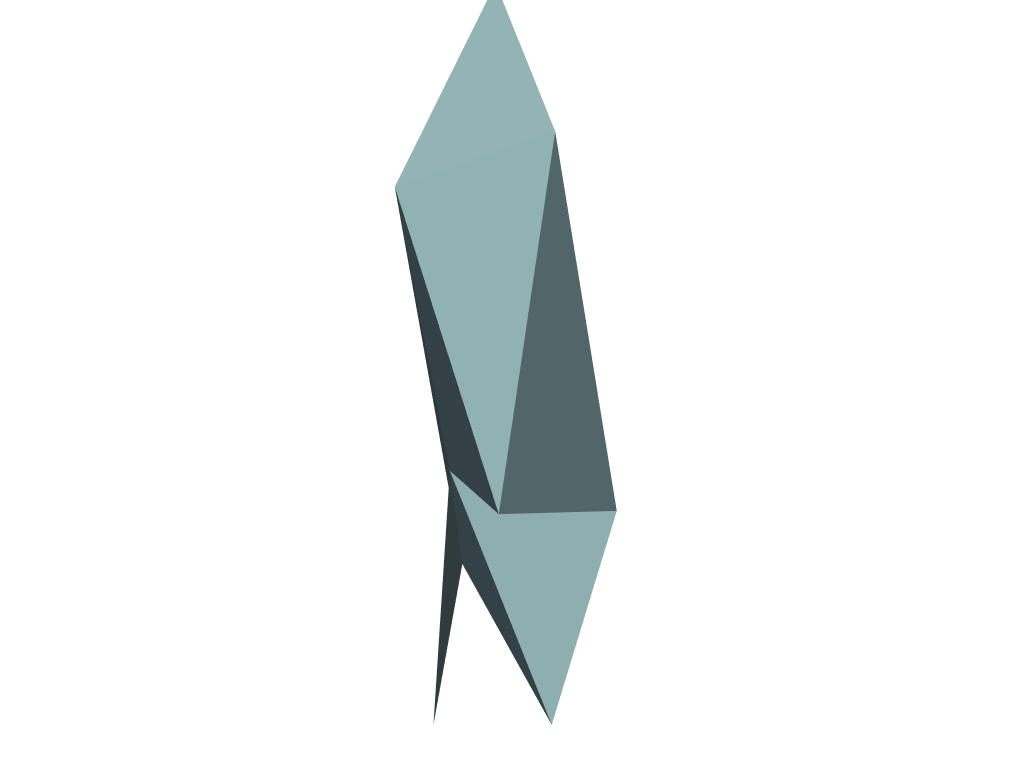
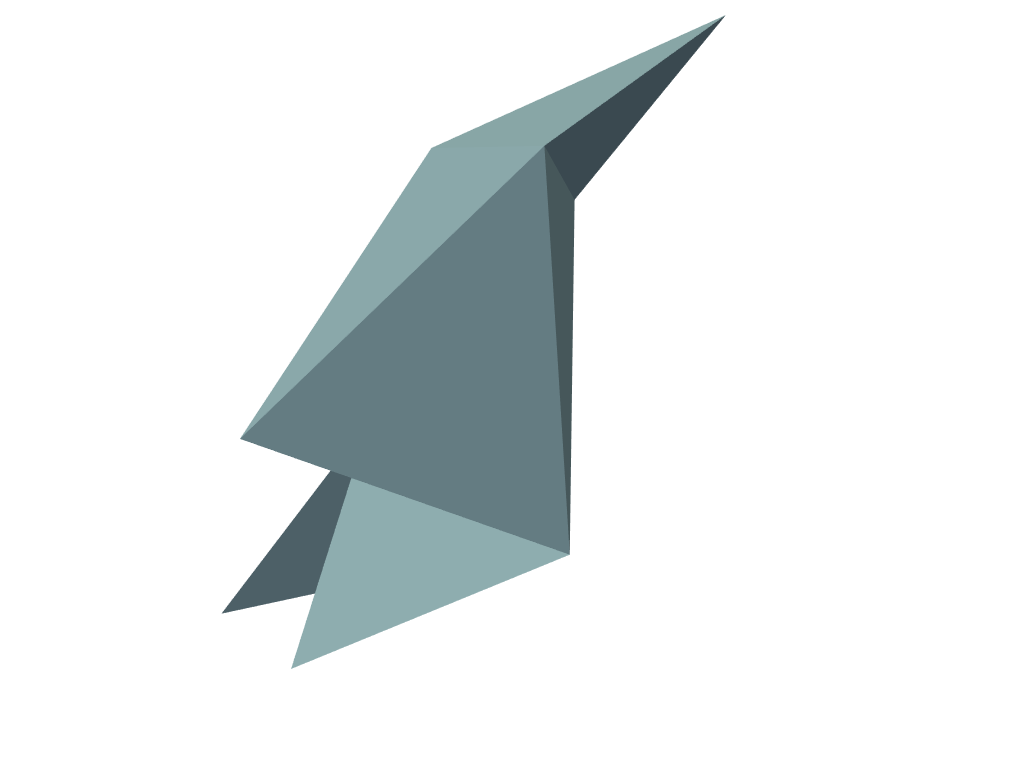
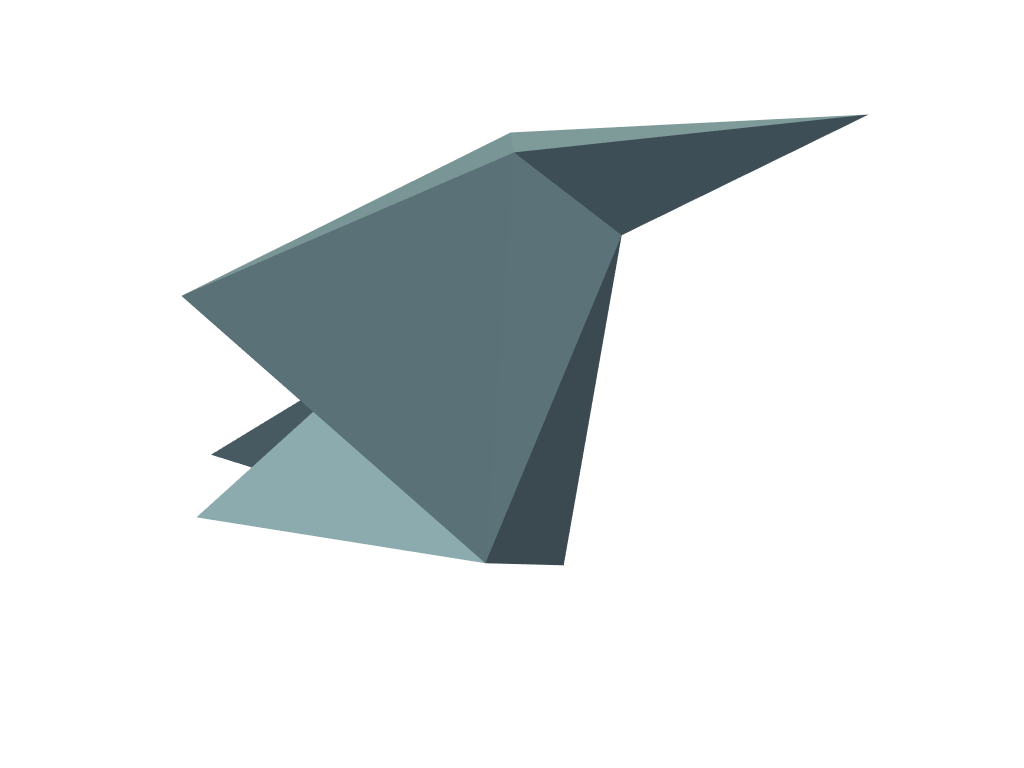

In [26]:

images_html = ""
for i, data_url in enumerate(att_low_poly.images):
    style = f"width:150px; display:inline-block; margin:2px; border:1px solid #ddd"
    images_html += f'<img src="{data_url}" style="{style}" />'
    if (i + 1) % 4 == 0:
        images_html += "<br>"
display(HTML(images_html))